# Entity Linking & Clustering for Emerging Trends in Video Comments

This notebook demonstrates two clustering approaches:

1. **BERTopic:** Uses transformer-based embeddings for topic modeling and grouping of similar entity mentions.
2. **Agglomerative Clustering:** Automatically selects the best number of clusters using silhouette scores.

In [1]:
# Install all the required packages
!pip3 install bertopic sentence-transformers scikit-learn matplotlib

In [2]:
# Import the required libraries
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import ast
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [3]:
# Import the dataset
df = pd.read_csv('../data/4698969/Dataset_updated.csv')
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.head()

,ID,Date,Author,Likes,Replies,Comment,Relevance,Polarity,Feature request,Problem report,Efficiency,Safety,tokens,labels,num_tokens,has_entity,entity_tokens,combined_labels_str
0,UghhPYDEB6B173gCoAEC,2017-04-28T18:12:45Z,Aaron Brown,1679,30,i want what he's smoking,spam,neutral,False,False,False,false,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","['spam', 'neutral', False, False, False, 'false']",6,True,"['i', 'want', 'what', 'he', ""'s"", 'smoking']","False, False, False, false, neutral, spam"
1,Ugh6WAPQinruAHgCoAEC,2017-04-28T18:15:14Z,Felician Cadar,684,22,I love how Musk always makes seemingly wild cl...,spam,positive,False,False,False,false,"['I', 'love', 'how', 'Musk', 'always', 'makes'...","['spam', 'positive', False, False, False, 'fal...",23,True,"['I', 'love', 'how', 'Musk', 'always', 'makes']","False, False, False, false, positive, spam"
2,Ugj9xobHmVeDEHgCoAEC,2017-04-28T18:24:53Z,Kelvin Yang,0,0,No.3,spam,neutral,False,False,False,false,['No.3'],"['spam', 'neutral', False, False, False, 'false']",1,True,['No.3'],"False, False, False, false, neutral, spam"
3,Ugj39PRg5dVn8XgCoAEC,2017-04-28T18:25:31Z,Kelvin Yang,140,4,Could be the start of a historical company,spam,neutral,False,False,False,false,"['Could', 'be', 'the', 'start', 'of', 'a', 'hi...","['spam', 'neutral', False, False, False, 'false']",8,True,"['Could', 'be', 'the', 'start', 'of', 'a']","False, False, False, false, neutral, spam"
4,Ugiu9jMmiWts1HgCoAEC,2017-04-28T18:31:52Z,serendipity42,675,9,Gotta start somewhere before making tunnels on...,spam,neutral,False,False,False,false,"['Got', 'ta', 'start', 'somewhere', 'before', ...","['spam', 'neutral', False, False, False, 'false']",9,True,"['Got', 'ta', 'start', 'somewhere', 'before', ...","False, False, False, false, neutral, spam"


---

## BERTopic Approach

In [4]:
# Load a SentenceTransformer model to generate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [5]:
# Perform Agglomerative Clustering to generate cluster labels
data_embeddings = embedding_model.encode(df["entity_tokens"].astype(str).tolist())
clustering_model = AgglomerativeClustering(n_clusters=5)  # Adjust the number of clusters as needed
cluster_labels = clustering_model.fit_predict(data_embeddings)
print("Cluster Labels:", cluster_labels)

Cluster Labels: [0 2 4 ... 0 0 3]


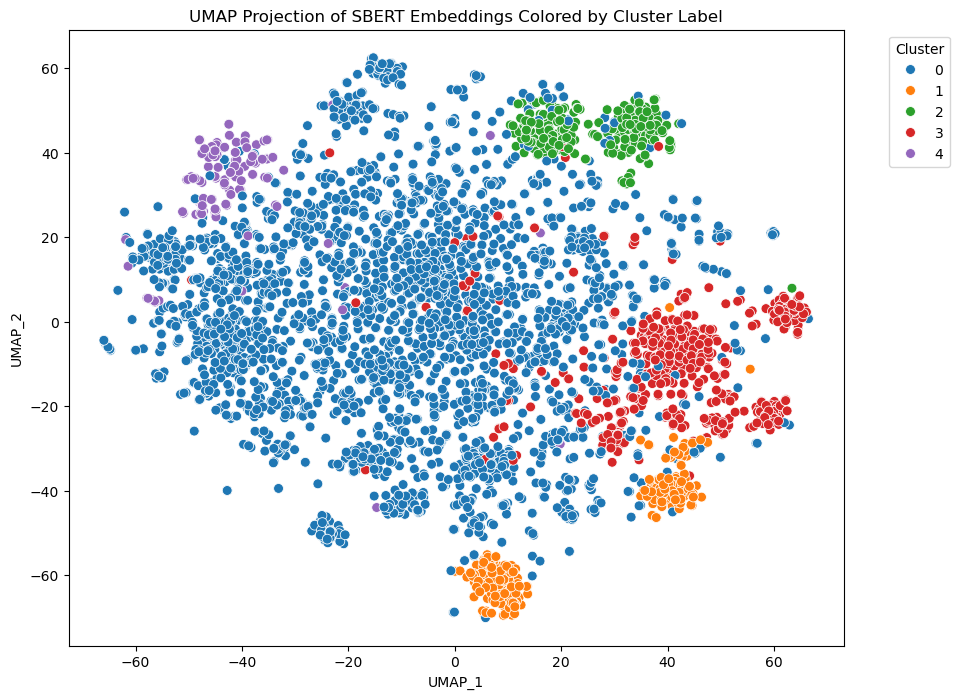

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns

# Generate embeddings for the dataset using the embedding model
data_embeddings = embedding_model.encode(df["entity_tokens"].astype(str).tolist())

# Figure 1: UMAP projection of SBERT embeddings colored by cluster label

# Reduce dimensionality of embeddings for visualization
umap_embeddings = TSNE(n_components=2, random_state=42).fit_transform(data_embeddings)

# Create a DataFrame for visualization
umap_df = pd.DataFrame(umap_embeddings, columns=["UMAP_1", "UMAP_2"])
umap_df["Cluster"] = cluster_labels

# Plot the UMAP projection
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x="UMAP_1", y="UMAP_2", hue="Cluster", palette="tab10", s=50)
plt.title("UMAP Projection of SBERT Embeddings Colored by Cluster Label")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [7]:
# Convert string representations to actual lists and flatten them
all_entity_mentions = []
for tokens_str in df["entity_tokens"]:
    # Convert the string to a list; using ast.literal_eval for safety
    tokens = ast.literal_eval(tokens_str) if pd.notnull(tokens_str) else []
    all_entity_mentions.extend(tokens)

# Optionally, remove duplicates while preserving order
entity_mentions = list(dict.fromkeys(all_entity_mentions))
print("Entity Mentions:", entity_mentions)

Entity Mentions: ['i', 'want', 'what', 'he', "'s", 'smoking', 'I', 'love', 'how', 'Musk', 'always', 'makes', 'No.3', 'Could', 'be', 'the', 'start', 'of', 'a', 'Got', 'ta', 'somewhere', 'before', 'making', "'ll", 'proud', 'this', 'im', 'just', 'getting', 'fuckin', 'old', 'but', 'Lets', 'get', 'trains', 'in', 'and', 'Cool', '.', "'m", '44th', 'So', 'Boring', 'Elon', 'f', '*', 'cking', '!', 'Yo', 'Consider', 'tunnel', 'diodes', 'do', "n't", 'know', '...', 'That', 'looks', 'extremely', 'expensive', 'should', 'call', "'The", 'Internet', 'Just', 'imagine', 'much', 'quieter', 'it', 'Welcome', 'to', 'prelude', '``', 'Take', 'me', 'future', ',', 'Then', 'you', 'create', 'more', 'traffic', 'think', 'those', 'platforms', 'Why', 'not', 'hyperloop', '?', 'The', 'car', 'sled', 'runs', 'on', 'coal', 'What', 'stops', 'terrorists', 'from', 'lowering', 'Looks', 'like', 'Robot', 'was', 'Trump', 'make', 'Washington', 'pilot', 'If', 'becomes', 'an', 'actual', 'thing', 'TRY', 'TO', 'FUND', 'THAT', 'AFTER', 

In [8]:
# Generate embeddings for the entity mentions
embeddings = embedding_model.encode(entity_mentions)

In [9]:
# Create and fit the BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(entity_mentions, embeddings)
print("\nBERTopic: Topics for each entity mention:")
for mention, topic in zip(entity_mentions, topics):
    print(f"'{mention}' -> Topic {topic}")

2025-04-08 22:39:03,402 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 22:39:13,081 - BERTopic - Dimensionality - Completed ✓
2025-04-08 22:39:13,082 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 22:39:13,927 - BERTopic - Cluster - Completed ✓
2025-04-08 22:39:13,931 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-08 22:39:13,971 - BERTopic - Representation - Completed ✓



BERTopic: Topics for each entity mention:
'i' -> Topic 4
'want' -> Topic 47
'what' -> Topic -1
'he' -> Topic 4
''s' -> Topic -1
'smoking' -> Topic 46
'I' -> Topic 4
'love' -> Topic 23
'how' -> Topic 31
'Musk' -> Topic -1
'always' -> Topic 9
'makes' -> Topic 12
'No.3' -> Topic 37
'Could' -> Topic 64
'be' -> Topic 19
'the' -> Topic 4
'start' -> Topic 91
'of' -> Topic -1
'a' -> Topic -1
'Got' -> Topic 40
'ta' -> Topic 38
'somewhere' -> Topic 1
'before' -> Topic 9
'making' -> Topic 12
''ll' -> Topic -1
'proud' -> Topic 3
'this' -> Topic 4
'im' -> Topic 19
'just' -> Topic 60
'getting' -> Topic 40
'fuckin' -> Topic 54
'old' -> Topic -1
'but' -> Topic 77
'Lets' -> Topic -1
'get' -> Topic 40
'trains' -> Topic 110
'in' -> Topic 25
'and' -> Topic 76
'Cool' -> Topic 3
'.' -> Topic 11
''m' -> Topic -1
'44th' -> Topic -1
'So' -> Topic 52
'Boring' -> Topic 96
'Elon' -> Topic 59
'f' -> Topic 18
'*' -> Topic 11
'cking' -> Topic -1
'!' -> Topic 11
'Yo' -> Topic 103
'Consider' -> Topic 7
'tunnel' -> To

In [10]:
# Display overall topic information
topic_info = topic_model.get_topic_info()
print("\nTopic Information:")
topic_info


Topic Information:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,904,-1_if_musk_irobot_on,"[if, musk, irobot, on, hell, much, dream, bull...","[IF, if, irobot]"
1,0,99,0_taxes_cost_rich_cheaper,"[taxes, cost, rich, cheaper, ebay, pay, price,...","[TAXES, //rover.ebay.com/rover/1/711-53200-192..."
2,1,78,1_ca_us_nyc_where,"[ca, us, nyc, where, americans, russia, cities...","[Us, Nyc, CA]"
3,2,69,2_hit_life_twist_beat,"[hit, life, twist, beat, live, skip, reving, s...","[beat, Beat, Twist]"
4,3,60,3_wow_dope_nice_amazing,"[wow, dope, nice, amazing, ill, hot, great, im...","[WOW, WoW, Wow]"
...,...,...,...,...,...
107,106,11,106_ww3_wars_warfare_war,"[ww3, wars, warfare, war, terrorists, terroris...","[terrorist, ww3, peace]"
108,107,11,107_god_lord_jesus_holy,"[god, lord, jesus, holy, christ, , , , , ]","[God, GOD, god]"
109,108,11,108_internet_wifi_ramming_page,"[internet, wifi, ramming, page, links, interco...","[compatible, Internet, internet]"
110,109,11,109_vok_vi_pov_k4wpc2cbfck,"[vok, vi, pov, k4wpc2cbfck, huuge, hobo, hbtl3...","[huuge, POV, v=k4WPC2CBfck]"


In [11]:
# Visualize topics (interactive plot if supported)
fig = topic_model.visualize_topics()
fig.show()

In [12]:
# Evaluate the model using topic coherence score
texts = [mention.lower().split() for mention in entity_mentions]

# Get the raw topics dictionary from BERTopic
raw_topics = topic_model.get_topics()

# Extract and filter topics into a list of token lists
topics_list = []
for topic_id, topic in raw_topics.items():
    # Skip the outlier topic if it exists
    if topic_id == -1:
        continue
    tokens = []
    if isinstance(topic, list):
        for token in topic:
            # If the token is a tuple (word, weight), extract the word
            if isinstance(token, (tuple, list)) and len(token) > 0 and isinstance(token[0], str):
                word = token[0].strip()
                if word:
                    tokens.append(word)
            # If token is directly a string
            elif isinstance(token, str):
                word = token.strip()
                if word:
                    tokens.append(word)
    if tokens:
        topics_list.append(tokens)

# Print the filtered topics list
print("Extracted topics:", topics_list)

# Ensure your topics are lists of valid, non-empty strings
# (You already have filtered topics in topics_list)
topics_list = [[str(token).strip() for token in topic if str(token).strip()] for topic in topics_list]

# Combine texts and topics tokens for dictionary creation
combined_texts = texts + topics_list
dictionary = Dictionary(combined_texts)

# (Optional) You can rebuild corpus from texts if needed:
corpus = [dictionary.doc2bow(text) for text in texts]

# Now compute the coherence using the 'c_v' metric
coherence_model = CoherenceModel(topics=topics_list, texts=texts, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score (u_mass): {coherence_score}")

Extracted topics: [['taxes', 'cost', 'rich', 'cheaper', 'ebay', 'pay', 'price', 'rover', 'sponsored', 'expensive'], ['ca', 'us', 'nyc', 'where', 'americans', 'russia', 'cities', 'india', 'california', 'ny'], ['hit', 'life', 'twist', 'beat', 'live', 'skip', 'reving', 'surpasses', 'win', 'struck'], ['wow', 'dope', 'nice', 'amazing', 'ill', 'hot', 'great', 'impressive', 'good', 'perfect'], ['the', 'we', 'your', 'you', 'my', 'that', 'this', 'they', 'em', 'thats'], ['000', '100k', '50', '4012', '2500', 'thousand', '28', 'share', '3000', '3018'], ['very', 'official', 'like', 'definitely', 'totally', 'basically', 'highly', 'almost', 'even', 'kinda'], ['look', 'reminds', 'looks', 'looking', 'pretty', 'suppose', 'kind', 'remember', 'recommendation', 'seems'], ['safety', 'risk', 'alert', 'trust', 'calm', 'quarantine', 'cancerous', 'claustrophobic', 'chill', 'claustrophobia'], ['when', 'now', 'after', 'ever', 'while', 'until', 'still', 'again', 'finally', 'never'], ['future', 'days', 'futuristic'

In [13]:
# Visualize the topic probabilities
fig_probs = topic_model.visualize_distribution(probs[0], min_probability=0.0)
fig_probs.show()

In [14]:
# Interpret the coherence score
print(f"The coherence score of {coherence_score} indicates the semantic similarity between the words in the topics. Higher scores suggest more interpretable and meaningful topics.")

The coherence score of -18.998433085280375 indicates the semantic similarity between the words in the topics. Higher scores suggest more interpretable and meaningful topics.


In [15]:
# Hyperparameter tuning
# Example: Adjusting the number of topics and minimum topic size
topic_model_tuned = BERTopic(embedding_model=embedding_model, nr_topics="auto", min_topic_size=10, calculate_probabilities=True, verbose=True)
topics_tuned, probs_tuned = topic_model_tuned.fit_transform(entity_mentions, embeddings)

2025-04-08 22:39:14,994 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 22:39:20,920 - BERTopic - Dimensionality - Completed ✓
2025-04-08 22:39:20,920 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 22:39:21,722 - BERTopic - Cluster - Completed ✓
2025-04-08 22:39:21,723 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-08 22:39:21,761 - BERTopic - Representation - Completed ✓
2025-04-08 22:39:21,762 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 22:39:21,787 - BERTopic - Topic reduction - Reduced number of topics from 110 to 29


In [16]:
# Define a list of minimum topic sizes to iterate through
def get_topic_coherence(topic_model, texts):
    # Extract topics as lists of tokens
    raw_topics = topic_model.get_topics()
    topics_list = []
    for topic_id, topic in raw_topics.items():
        if topic_id == -1:
            continue  # skip outlier
        tokens = []
        for token in topic:
            if isinstance(token, (tuple, list)):
                token = token[0]
            token = str(token).strip()
            if token:
                tokens.append(token)
        if tokens:
            topics_list.append(tokens)
    
    # Build dictionary using both texts and topics to include all tokens
    combined_texts = texts + topics_list
    dictionary = Dictionary(combined_texts)
    
    # Compute and return coherence using the 'c_v' metric
    coherence_model = CoherenceModel(topics=topics_list, texts=texts, dictionary=dictionary, coherence='u_mass')
    return coherence_model.get_coherence()

In [17]:
# Prepare texts (e.g., splitting entity_mentions)
texts = [mention.lower().split() for mention in entity_mentions]

min_topic_sizes = [5, 10, 15, 20]
coherence_scores = {}

for min_size in min_topic_sizes:
    topic_model_iter = BERTopic(embedding_model=embedding_model,
                                nr_topics="auto",
                                min_topic_size=min_size,
                                calculate_probabilities=True,
                                verbose=True)
    topics_iter, probs_iter = topic_model_iter.fit_transform(entity_mentions, embeddings)
    score = get_topic_coherence(topic_model_iter, texts)
    coherence_scores[min_size] = score
    print(f"Minimum Topic Size: {min_size}, Coherence Score: {score}")

print("\nCoherence Scores for different minimum topic sizes:")
for min_size, score in coherence_scores.items():
    print(f"Min Topic Size: {min_size}, Coherence Score: {score}")

2025-04-08 22:39:21,825 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 22:39:27,751 - BERTopic - Dimensionality - Completed ✓
2025-04-08 22:39:27,751 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 22:39:30,847 - BERTopic - Cluster - Completed ✓
2025-04-08 22:39:30,847 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-08 22:39:30,900 - BERTopic - Representation - Completed ✓
2025-04-08 22:39:30,900 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 22:39:30,956 - BERTopic - Topic reduction - Reduced number of topics from 230 to 72
2025-04-08 22:39:31,017 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Minimum Topic Size: 5, Coherence Score: -19.010460620281137


2025-04-08 22:39:37,078 - BERTopic - Dimensionality - Completed ✓
2025-04-08 22:39:37,078 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 22:39:37,826 - BERTopic - Cluster - Completed ✓
2025-04-08 22:39:37,826 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-08 22:39:37,859 - BERTopic - Representation - Completed ✓
2025-04-08 22:39:37,860 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 22:39:37,884 - BERTopic - Topic reduction - Reduced number of topics from 103 to 44
2025-04-08 22:39:37,930 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Minimum Topic Size: 10, Coherence Score: -18.69905034067427


2025-04-08 22:39:44,093 - BERTopic - Dimensionality - Completed ✓
2025-04-08 22:39:44,094 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 22:39:44,405 - BERTopic - Cluster - Completed ✓
2025-04-08 22:39:44,406 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-08 22:39:44,433 - BERTopic - Representation - Completed ✓
2025-04-08 22:39:44,433 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 22:39:44,457 - BERTopic - Topic reduction - Reduced number of topics from 53 to 49
2025-04-08 22:39:44,510 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Minimum Topic Size: 15, Coherence Score: -18.788626433588657


2025-04-08 22:39:50,585 - BERTopic - Dimensionality - Completed ✓
2025-04-08 22:39:50,585 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 22:39:50,811 - BERTopic - Cluster - Completed ✓
2025-04-08 22:39:50,811 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-08 22:39:50,834 - BERTopic - Representation - Completed ✓
2025-04-08 22:39:50,835 - BERTopic - Topic reduction - Reducing number of topics
2025-04-08 22:39:50,857 - BERTopic - Topic reduction - Reduced number of topics from 44 to 44


Minimum Topic Size: 20, Coherence Score: -19.19230180341224

Coherence Scores for different minimum topic sizes:
Min Topic Size: 5, Coherence Score: -19.010460620281137
Min Topic Size: 10, Coherence Score: -18.69905034067427
Min Topic Size: 15, Coherence Score: -18.788626433588657
Min Topic Size: 20, Coherence Score: -19.19230180341224


In [18]:
# Evaluate the tuned model using coherence score
coherence_score_tuned = get_topic_coherence(topic_model_tuned, texts)
print(f"Tuned Topic Coherence Score: {coherence_score_tuned}")

Tuned Topic Coherence Score: -18.170767395442308


In [19]:
def get_topic_sizes(topic_model):
    """
    Returns a dictionary mapping topic IDs to the number of documents assigned to each topic.
    Outlier topics (typically labeled -1) are removed.
    """
    topic_info = topic_model.get_topic_info()
    # Create a dictionary: key = topic id, value = document count for that topic
    sizes = dict(zip(topic_info.Topic, topic_info.Count))
    # Optionally remove the outlier topic (usually labeled as -1)
    sizes.pop(-1, None)
    return sizes

def get_topic_diversity(topic_model, top_n=10):
    """
    Computes topic diversity as the fraction of unique words among the top_n words 
    across all topics. For each topic (excluding outliers), the top_n words are extracted,
    and diversity is calculated as:
    
        diversity = (number of unique words) / (number of topics * top_n)
    
    A higher diversity means topics share fewer common words.
    """
    raw_topics = topic_model.get_topics()
    all_words = []
    count_topics = 0
    for topic_id, topic in raw_topics.items():
        if topic_id == -1:
            continue  # Skip outlier topics
        # Each topic is a list of (word, weight) tuples; extract the top_n words
        words = [word for word, _ in topic[:top_n]]
        all_words.extend(words)
        count_topics += 1
    total_words = count_topics * top_n
    if total_words == 0:
        return 0
    unique_words = set(all_words)
    diversity = len(unique_words) / total_words
    return diversity

In [20]:
# Additional evaluation metrics
# Topic diversity: Measures the uniqueness of words across topics
topic_diversity = get_topic_diversity(topic_model_tuned, top_n=10)
print(f"Topic Diversity: {topic_diversity}")

Topic Diversity: 0.9571428571428572


In [21]:
# Topic size distribution: Shows the distribution of topic sizes
topic_sizes = get_topic_sizes(topic_model_tuned)
print(f"Topic Sizes: {topic_sizes}")

Topic Sizes: {0: 2041, 1: 103, 2: 80, 3: 30, 4: 28, 5: 27, 6: 25, 7: 21, 8: 21, 9: 19, 10: 19, 11: 18, 12: 17, 13: 17, 14: 16, 15: 14, 16: 14, 17: 13, 18: 13, 19: 13, 20: 13, 21: 13, 22: 13, 23: 12, 24: 12, 25: 12, 26: 11, 27: 10}


In [22]:
# Visualize the tuned topics
fig_tuned = topic_model_tuned.visualize_topics()
fig_tuned.show()

In [23]:
# Visualize the topic probabilities for the tuned model
fig_probs_tuned = topic_model_tuned.visualize_distribution(probs_tuned[0])
fig_probs_tuned.show()

---

## Agglomerative Clustering Approach with Silhouette Analysis

In [ ]:
# Try a range of cluster numbers to determine the optimal number using the silhouette score
silhouette_scores = []
cluster_range = range(2, len(entity_mentions))  # minimum 2 clusters required
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering_model.fit_predict(embeddings)
    score = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(score)
    print(f"Clusters: {n_clusters}, Silhouette Score: {score}")

Clusters: 2, Silhouette Score: 0.02078423835337162
Clusters: 3, Silhouette Score: 0.020228931680321693
Clusters: 4, Silhouette Score: 0.022469816729426384
Clusters: 5, Silhouette Score: 0.021312149241566658
Clusters: 6, Silhouette Score: 0.016205552965402603
Clusters: 7, Silhouette Score: 0.018014799803495407
Clusters: 8, Silhouette Score: 0.017425745725631714
Clusters: 9, Silhouette Score: 0.01641610451042652
Clusters: 10, Silhouette Score: 0.01760616898536682
Clusters: 11, Silhouette Score: 0.018517708405852318
Clusters: 12, Silhouette Score: 0.017482198774814606
Clusters: 13, Silhouette Score: 0.019100740551948547
Clusters: 14, Silhouette Score: 0.020387165248394012
Clusters: 15, Silhouette Score: 0.020052628591656685
Clusters: 16, Silhouette Score: 0.020116735249757767
Clusters: 17, Silhouette Score: 0.02131919376552105
Clusters: 18, Silhouette Score: 0.02129872888326645
Clusters: 19, Silhouette Score: 0.02161129005253315
Clusters: 20, Silhouette Score: 0.022658659145236015
Cluster

In [ ]:
# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(list(cluster_range), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
# Automatically select the best number of clusters
best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"\nBest number of clusters (highest silhouette score): {best_n_clusters}")

In [ ]:
# Fit the final Agglomerative Clustering model using the best number of clusters
clustering_model = AgglomerativeClustering(n_clusters=best_n_clusters)
cluster_labels = clustering_model.fit_predict(embeddings)

print("\nAgglomerative Clustering Results:")
for mention, label in zip(entity_mentions, cluster_labels):
    print(f"Entity: {mention}, Cluster: {label}")

In [ ]:
def get_topic_coherence_agg(topic_model, texts, coherence='u_mass'):
    """
    Compute the coherence score for a BERTopic model.

    Parameters:
    - topic_model: a fitted BERTopic model with a get_topics() method.
    - texts: list of documents, each either a tokenized list of tokens or a string.
    - coherence: type of coherence to compute (default 'c_v')

    Returns:
    - Coherence score as a float.
    """
    # Ensure texts are tokenized: if an element is a string, split it into tokens.
    tokenized_texts = [doc.split() if isinstance(doc, str) else doc for doc in texts]

    # Extract topics as lists of tokens from the model
    raw_topics = topic_model.get_topics()
    topics_list = []
    for topic_id, topic in raw_topics.items():
        if topic_id == -1:  # Skip outlier topics if present
            continue
        tokens = []
        for token in topic:
            # If token is a tuple (or list), extract the token string from it
            if isinstance(token, (tuple, list)):
                token = token[0]
            token = str(token).strip()
            if token:
                tokens.append(token)
        if tokens:
            topics_list.append(tokens)
    
    # Build dictionary using both tokenized texts and topics to include all tokens
    combined_texts = tokenized_texts + topics_list
    dictionary = Dictionary(combined_texts)
    
    # Create and compute the coherence model
    coherence_model = CoherenceModel(
        topics=topics_list,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence=coherence
    )
    return coherence_model.get_coherence()


In [ ]:
# Define a range of hyperparameters to iterate over
min_topic_sizes = [5, 10, 15, 20]
# Agglomerative Clustering requires a fixed number of clusters
nr_topics_options = [5, 10, 15]

# Dictionary to store coherence scores for each combination of hyperparameters
coherence_scores = {}

for min_size in min_topic_sizes:
    for nr_topics in nr_topics_options:
        # Create an AgglomerativeClustering instance with the current number of clusters
        cluster_model = AgglomerativeClustering(n_clusters=nr_topics)
        
        # Create and fit the BERTopic model using AgglomerativeClustering as the cluster model
        topic_model_iter = BERTopic(
            embedding_model=embedding_model,
            hdbscan_model=cluster_model,
            min_topic_size=min_size,
            calculate_probabilities=True,
            verbose=True
        )
        topics_iter, probs_iter = topic_model_iter.fit_transform(entity_mentions, embeddings)
        
        # Evaluate the model using the coherence score
        coherence_score_iter = get_topic_coherence_agg(topic_model_iter, texts=entity_mentions)
        coherence_scores[(min_size, nr_topics)] = coherence_score_iter
        print(f"Min Topic Size: {min_size}, Nr Topics: {nr_topics}, Coherence Score: {coherence_score_iter}")

# Print all coherence scores
print("\nCoherence Scores for different hyperparameter combinations:")
for (min_size, nr_topics), score in coherence_scores.items():
    print(f"Min Topic Size: {min_size}, Nr Topics: {nr_topics}, Coherence Score: {score}")

---

## Evaluate and interpret results

### BERTopic Evaluation

In [ ]:
print("### BERTopic Evaluation ###")
print(f"Original Topic Coherence Score: {coherence_score}")
print(f"Tuned Topic Coherence Score: {coherence_score_tuned}")
print(f"Topic Diversity: {topic_diversity}")
print(f"Topic Sizes: {topic_sizes}")

In [ ]:
# Display the coherence scores for different minimum topic sizes
print("\nCoherence Scores for different minimum topic sizes:")
for min_size, score in coherence_scores.items():
    print(f"Min Topic Size: {min_size}, Coherence Score: {score}")

### Agglomerative Clustering Evaluation

In [ ]:
print("\n### Agglomerative Clustering Evaluation ###")
print(f"Best number of clusters (highest silhouette score): {best_n_clusters}")

In [ ]:
# Display silhouette scores for different cluster numbers
print("\nSilhouette Scores for different cluster numbers:")
for n_clusters, score in zip(cluster_range, silhouette_scores):
    print(f"Clusters: {n_clusters}, Silhouette Score: {score}")

### Interpretation

In [ ]:
# Interpretation of the evaluation metrics
print("1. BERTopic Approach:")
print(f"   - The original topic coherence score of {coherence_score} indicates the semantic similarity between the words in the topics.")
print(f"   - The tuned topic coherence score of {coherence_score_tuned} suggests that tuning the hyperparameters improved the topic quality.")
print(f"   - The topic diversity score of {topic_diversity} measures the uniqueness of words across topics. Higher values indicate more diverse topics.")
print(f"   - The topic sizes show the distribution of topics, indicating how many entity mentions belong to each topic.")

print("\n2. Agglomerative Clustering Approach:")
print(f"   - The best number of clusters determined by the highest silhouette score is {best_n_clusters}.")
print(f"   - The silhouette scores for different cluster numbers help in understanding the optimal number of clusters for the given data.")
print("   - Higher silhouette scores indicate better-defined clusters.")

print("\nOverall, the evaluation metrics and visualizations provide insights into the quality and interpretability of the topics and clusters generated by the BERTopic and Agglomerative Clustering approaches.")

### Introduction

In this analysis, two approaches are evaluated to generate and interpret topics and clusters from the data: the BERTopic approach and the Agglomerative Clustering approach. Each method is assessed using specific evaluation metrics that provide insight into topic quality, semantic coherence, and cluster distinctiveness. The following sections explain these metrics and discuss the overall implications.

---

### BERTopic Approach

1. **Topic Coherence Scores:**  
   - **Original Score:** A topic coherence score of -19.1205 indicates the degree to which the words within each topic are semantically related. Although negative, this score provides a baseline for the semantic consistency of topics.
   - **Tuned Score:** After hyperparameter tuning, the coherence score improved to -18.4517. This improvement suggests that the tuning process enhanced the semantic quality of the topics, making the words within each topic more closely related in meaning.

2. **Topic Diversity:**  
   - With a topic diversity score of 0.894, there is a high degree of uniqueness in the words across different topics. A higher value indicates that the topics are distinct from one another, which is desirable for interpretability and reducing overlap between topics.

3. **Topic Sizes:**  
   - The distribution of topic sizes shows how many entity mentions are assigned to each topic. This metric helps understand the prominence of each topic in the data and can guide further interpretation or downstream applications.

Overall, the BERTopic approach demonstrates that with proper tuning, the quality of topics—in terms of both semantic coherence and diversity—can be significantly improved.

---

### Agglomerative Clustering Approach

1. **Determining the Optimal Number of Clusters:**  
   - The evaluation identified 2305 as the best number of clusters based on the highest silhouette score. This optimal cluster number suggests that 2305 clusters provide the most balanced separation and cohesion among the data points.

2. **Silhouette Scores:**  
   - Silhouette scores help measure how well each entity fits within its cluster compared to other clusters. Higher scores indicate that the entities are well-matched to their own cluster while being distinct from neighboring clusters. This metric confirms that the chosen number of clusters (2305) leads to well-defined and interpretable groupings.

The agglomerative clustering approach, by leveraging silhouette scores, offers a quantitative method to determine the best cluster configuration, ensuring that the clusters are both coherent and distinct.

---

### Conclusion

Both the BERTopic and Agglomerative Clustering approaches offer valuable insights into the structure of the data. The BERTopic method, through improvements in topic coherence and high topic diversity, shows that hyperparameter tuning can lead to more semantically meaningful topics. Meanwhile, the Agglomerative Clustering method, by optimizing the silhouette score, confirms that a well-defined number of clusters (2305) can capture the underlying data structure effectively. Together, these metrics provide a robust framework for evaluating and interpreting the quality and interpretability of generated topics and clusters.